In [1]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [24]:
# import (or reload) modules
import src.models
reload(src.models)
from src.models import *

import src.data_methods
reload(src.data_methods)
from src.data_methods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

## Many To One
This notebook contains the steps necessary to train a 'many to one' lstm model - that is, a model in which many time steps are given as input, and one prediction is given as output.

### Gestures
First, get a list of gestures from the gestures parameter file, and dictionaries mapping between gesture names and their integer ids.

In [113]:
gestures, g2idx, idx2g = get_gestures(version=3)

### Dictionaries for Standardizing/Centering 
Sometimes we want to update the dictionaries used for normalizing and centering variables. We need to do this if a new variable is introduced for which the information is not in the dictionary.
CSV2examples can generate new dictionaries for this purpose, overwriting the old ones stored in the params/ folder.

In [ ]:
n_frames=40
CSV2examples(raw_file='data/recordings/normalization_data.csv', g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=True, derive_features=True)

### Read in folder of CSV files, set up a model, and train

In [114]:
n_frames = 10
target_fps = 5
X, y = folder2examples(folder='data/loopsV3/train/', g2idx=g2idx, n_frames=n_frames, mirror=True, target_fps=target_fps)
print('\n### retrieving validation data ###')
X_val, y_val = folder2examples(folder='data/loopsV3/test/', g2idx=g2idx, n_frames=n_frames, mirror=True, target_fps=target_fps)
print(X.shape)

 
<DirEntry '1loopv3anon.csv'>
mean fps: 27.06
target fps: 5
taking every 5 frames
100.00% of rows contain valid LH data
98.16% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
 
<DirEntry 'loopv3Andrew_flat_LHpart1.csv'>


C:\Users\Andrew\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


mean fps: 27.64
target fps: 5
taking every 6 frames
30.98% of rows contain valid LH data
30.98% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
 
<DirEntry 'loopv3Andrew_flat_LHpart2.csv'>
mean fps: 26.80
target fps: 5
taking every 5 frames
99.40% of rows contain valid LH data
99.87% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
 
<DirEntry 'supplemental1.csv'>
mean fps: 28.78
target fps: 5
taking every 6 frames
98.82% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
 
<DirEntry 'v3loop_andrew_lowfps.csv'>
mean fps: 21.49
target fps: 5
taking every 4 frames
99.75% of rows contain valid LH data
99.97% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
 
<DirEntry 'V3_1loop_nick.csv'>
mean fps: 27.62
target fps: 5
taking every 6 frames
96.21% of rows contain valid LH data
99.15% of rows contain vali

### Model Training

In [115]:
rnn_units = 5
recurrent_dropout = 0.7
bidirectional = True
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx),
                       n_lstm_layers=1, rnn_units=rnn_units, recurrent_dropout=recurrent_dropout, bidirectional=bidirectional)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 10, 50)]          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 10)                2240      
_________________________________________________________________
dense_12 (Dense)             (None, 31)                341       
Total params: 2,581
Trainable params: 2,581
Non-trainable params: 0
_________________________________________________________________


In [116]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=100, batch_size = 50)

Train on 5468 samples, validate on 496 samples
Epoch 1/100
5468/5468 [==============================] - 4s 790us/sample - loss: 3.3217 - accuracy: 0.0817 - val_loss: 3.1240 - val_accuracy: 0.1452
Epoch 2/100
5468/5468 [==============================] - 1s 205us/sample - loss: 2.9940 - accuracy: 0.2074 - val_loss: 2.7972 - val_accuracy: 0.3286
Epoch 3/100
5468/5468 [==============================] - 1s 174us/sample - loss: 2.6841 - accuracy: 0.3164 - val_loss: 2.4832 - val_accuracy: 0.4435
Epoch 4/100
5468/5468 [==============================] - 1s 180us/sample - loss: 2.3807 - accuracy: 0.4018 - val_loss: 2.2000 - val_accuracy: 0.4879
Epoch 5/100
5468/5468 [==============================] - 1s 176us/sample - loss: 2.1034 - accuracy: 0.4894 - val_loss: 1.9403 - val_accuracy: 0.5746
Epoch 6/100
5468/5468 [==============================] - 1s 173us/sample - loss: 1.8600 - accuracy: 0.5746 - val_loss: 1.7011 - val_accuracy: 0.6875
Epoch 7/100
5468/5468 [==============================] - 1s

### Save Model

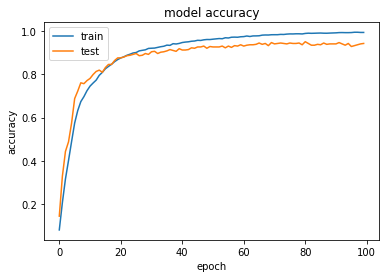

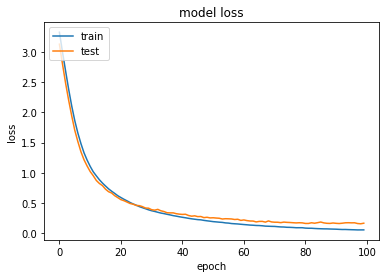

<Figure size 432x288 with 0 Axes>

In [119]:
# save trained model
final_test_acc = history.history['val_accuracy'][-1]
models_folder = 'models/v3/'
model_configuration = f'{final_test_acc:.2f}acc_{n_frames}f_{rnn_units}hs_bi_{target_fps}fps'
model_path = models_folder + model_configuration + '/'
os.makedirs(model_path)
model.save(model_path + model_configuration + '.h5')
with open(model_path + 'description.txt', 'w') as f:
    f.write(f'example length: {n_frames}\n')
    f.write(f'fps: {target_fps}\n')
    f.write(f'hidden_state: {rnn_units}\n')
    f.write(f'recurrent_dropout: {recurrent_dropout}\n')
    f.write(f'inputs: {X.shape[-1]}\n')
    f.write(f'outputs: {len(g2idx)}\n')

plt_metric(history, 'accuracy')
plt.savefig(model_path + 'accuracy')
plt.clf()
plt_metric(history, 'loss')
plt.savefig(model_path + 'loss')
plt.clf()

### Evaluate model training progress and accuracy

In [24]:
# If required, load a specific CSV of test data
X_test, y_test = CSV2examples('recordings/cputest-maxed.csv', g2idx=g2idx, n_frames=40)

mean fps: 20.82
target fps: 25
taking every 1 frames
100.00% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 1600 rows with nans
dealt with 0 of 1600 rows with nans
Data successfully mirrored


In [20]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print('Example number ',i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print('Probability: ', np.max(pred))
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

76
[[5.1329839e-03 1.2742927e-04 1.3233292e-03 8.1423987e-03 3.8563199e-02
  1.0936646e-02 7.2512496e-01 2.1064912e-01]]
Predicted:  shuffle_over
Truth:  shuffle_over


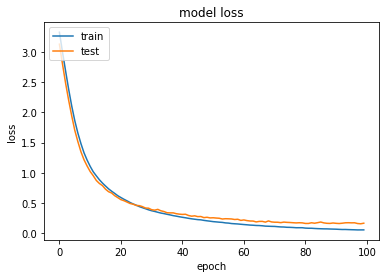

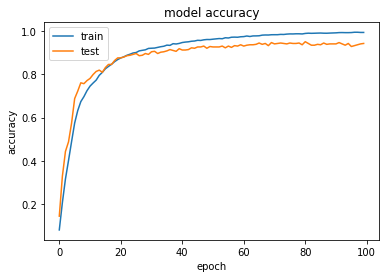

In [117]:
# plot training history
plt_metric(history, 'loss')
plt.show()
plt_metric(history, 'accuracy')
plt.show()

In [118]:
# get accuracy for each gesture
# this acheives this using pd.crosstab, which essentially gets the confusion matrix

pred = np.argmax(model.predict(X_val), axis=-1)

c_matrix = pd.crosstab(y_val, pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')

accuracy = {g: 0 for g in g2idx.keys()}
for i in c_matrix.index:
    if i not in c_matrix.columns:
        pass
    else:
        accuracy[idx2g[i]] = round(c_matrix.loc[i,i],2)

print(sorted(accuracy.items(), key=lambda x: x[1]))

[('multiple', 0.62), ('thumbs_up', 0.69), ('path', 0.75), ('wave', 0.81), ('open_close', 0.88), ('this_big', 0.88), ('love_heart_set', 0.88), ('smoothing_sand', 0.88), ('stop', 0.94), ('counting_hands_together', 0.94), ('small', 0.94), ('no_gesture', 1.0), ('call_me', 1.0), ('fist', 1.0), ('gun', 1.0), ('maybe', 1.0), ('ok', 1.0), ('peace', 1.0), ('pointing', 1.0), ('shuffle_over', 1.0), ('so_so', 1.0), ('thumbs_down', 1.0), ('typing', 1.0), ('finger_drawing', 1.0), ('triangle_set', 1.0), ('circle_set', 1.0), ('driving', 1.0), ('why', 1.0), ('gather_leaves', 1.0), ('robotic_arm', 1.0), ('cup_hands', 1.0)]


('middle_finger', 0.04), ('wave', 0.46), ('multiple', 0.75), ('thumbs_up', 0.83), ('small', 0.83), ('smoothing_sand', 0.83), ('counting_hands_together', 0.88), ('finger_drawing', 0.88), ('fist', 0.92), ('gun', 0.92), ('this_big', 0.92), ('driving', 0.92), ('drawing', 0.92), ('peace', 0.96)

Wave and middle finger most urgent, not being recognized at all.
stop and peace, redo. 

In [69]:
# get confusion matrix
pred = np.argmax(model.predict(X), axis=-1)

c_matrix = pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')

accuracy = {g: 0 for g in g2idx.keys()}
for i in c_matrix.index:
    if i not in c_matrix.columns:
        pass
    else:
        accuracy[idx2g[i]] = round(c_matrix.loc[i,i],2)

print(sorted(accuracy.items(), key=lambda x: x[1]))

[('multiple', 0.85), ('this_big', 0.88), ('path', 0.88), ('gather_leaves', 0.92), ('wave', 0.93), ('shuffle_over', 0.94), ('smoothing_sand', 0.94), ('pointing', 0.95), ('so_so', 0.95), ('finger_drawing', 0.95), ('peace', 0.97), ('stop', 0.97), ('thumbs_up', 0.97), ('small', 0.97), ('why', 0.97), ('cup_hands', 0.97), ('call_me', 0.98), ('maybe', 0.98), ('robotic_arm', 0.98), ('no_gesture', 0.99), ('fist', 0.99), ('open_close', 0.99), ('thumbs_down', 0.99), ('gun', 1.0), ('ok', 1.0), ('typing', 1.0), ('counting_hands_together', 1.0), ('triangle_set', 1.0), ('circle_set', 1.0), ('love_heart_set', 1.0), ('driving', 1.0)]
